In [31]:
import json
import numpy as np
import soundfile as sf
import librosa as lr
import pyroomacoustics as pra
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import scipy as sp
from scipy.io import wavfile


from tqdm import tqdm
from pathlib import Path

from pprint import pprint

# Load data

In [32]:
path_to_data = Path('./datanet/projects/otohikari/robin/measurements/20171207/')
# load parameters from config file json
path_to_config = path_to_data / 'protocol.json'
with open(path_to_config) as json_file:
    config = json.load(json_file)

In [33]:
pprint(config)

{'conditions': {'humidity': 58.0, 'temperature': 22.0},
 'equipment': {'camera': 'Olympus Pen E-PL2',
               'microphones': ['Pyramic 48 MEMS microphone array, see '
                               'https://github.com/LCAV/Pyramic',
                               'Olympus ME51S'],
               'sound2light': ['First Raspberry Pi prototype'],
               'speakers': 'Bose Micro Music Monitor'},
 'geometry': {'microphones': {'olympus': {'comment': 'The two microphones were '
                                                     'placed horizontally with '
                                                     'respect to the floor, '
                                                     'with left/right matching '
                                                     'the orientation of the '
                                                     'camera. The microphones '
                                                     'were placed 25 cm to the '
                              

In [34]:
room_dim = config['geometry']['room']
mic_pos = np.array(config['geometry']['microphones']['pyramic']['locations']) 
ref_pos = np.array(config['geometry']['microphones']['pyramic']['reference'])
src_pos = np.array(config['geometry']['speakers']['locations']) # [noise, speech]

temperature = config['conditions']['temperature']
humidity = config['conditions']['humidity']

print('Room dimensions:', room_dim)
print('Microphones positions:', mic_pos.shape)
print('Array position:', ref_pos.shape)
print('Speakers positions:', src_pos.shape)

print(ref_pos)
print(src_pos)

Room dimensions: [8.945, 7.421, 2.6]
Microphones positions: (48, 3)
Array position: (3,)
Speakers positions: (2, 3)
[3.55  6.611 0.875]
[[5.695 4.22  0.85 ]
 [6.778 6.656 0.85 ]]


In [35]:
mic_idx = list(range(8, 16)) + list(range(24, 32)) + list(range(40, 48)) # flat part
mic_pos = mic_pos[mic_idx, :]

mic_pos -= np.mean(mic_pos, axis=0)[None, :]
mic_pos[:, 2] -= np.max(mic_pos[:, 2])
mic_pos += ref_pos
print(mic_pos.shape)

(24, 3)


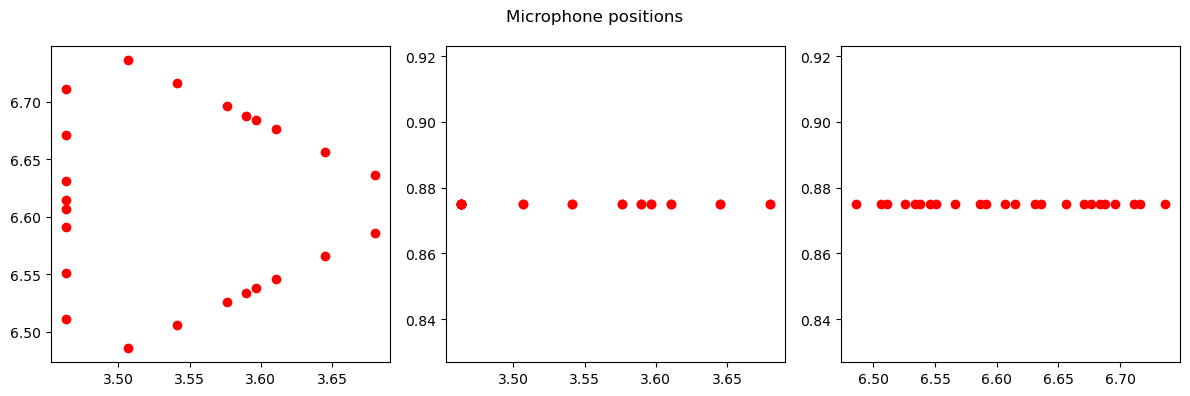

In [36]:
plt.figure(figsize=(12,4))
plt.suptitle('Microphone positions')
plt.subplot(1,3,1)
plt.scatter(mic_pos[:,0], mic_pos[:,1], c='r')
plt.subplot(1,3,2)
plt.scatter(mic_pos[:,0], mic_pos[:,2], c='r')
plt.subplot(1,3,3)
plt.scatter(mic_pos[:,1], mic_pos[:,2], c='r')
plt.tight_layout()
plt.show()

In [37]:
# PARAMS
MIC = "pyramic_audio"
SIR = "5"
NFFT = 1024

vad_guard = 1024

In [38]:
# LOAD DATA
file_pattern = "segmented/{}_{}_SIR_{}_dB.wav"
file_speech_ref = "segmented/{}_speech_ref.wav"

mix, fs_mix = sf.read(path_to_data / file_pattern.format(MIC, "mix", SIR))
print('mix', mix.shape, fs_mix)
led, fs_led = sf.read(path_to_data / file_pattern.format("camera_leds_zero_hold", "mix", SIR))
assert fs_mix == fs_led
print('led', led.shape, fs_led)

noise_ref, fs_nse = sf.read(path_to_data / file_pattern.format(MIC, "noise_ref", SIR))
assert fs_mix == fs_nse
print('noise_ref', noise_ref.shape, fs_nse)
speech_ref, fs_src = sf.read(path_to_data / file_speech_ref.format(MIC))
assert fs_mix == fs_src
print('speech_ref', speech_ref.shape, fs_src)

fs = fs_mix


mix (287659, 48) 16000
led (287659,) 16000
noise_ref (287659, 48) 16000
speech_ref (287659, 48) 16000


In [39]:
# select mic index
mix = mix[:, mic_idx]
noise_ref = noise_ref[:, mic_idx]
speech_ref = speech_ref[:, mic_idx]

print('mix', mix.shape)
print('noise_ref', noise_ref.shape)
print('speech_ref', speech_ref.shape)

mix (287659, 24)
noise_ref (287659, 24)
speech_ref (287659, 24)


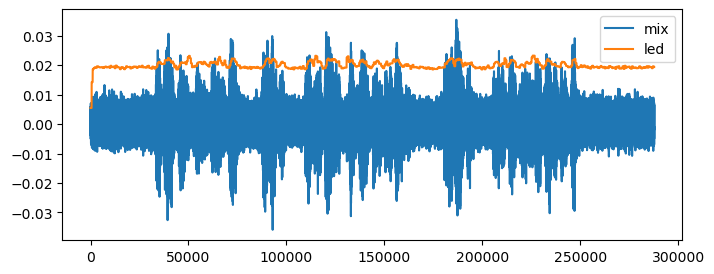

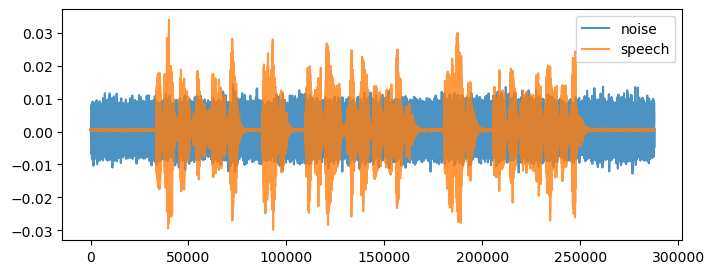

In [40]:
plt.figure(figsize=(8,3))
plt.plot(mix[:,0], label='mix')
plt.plot(led, label='led')
plt.legend()
plt.show()

plt.figure(figsize=(8,3))
plt.plot(noise_ref[:,0], label='noise', alpha=0.8)
plt.plot(speech_ref[:,0], label='speech', alpha=0.8)
plt.legend()
plt.show()

32767
32768


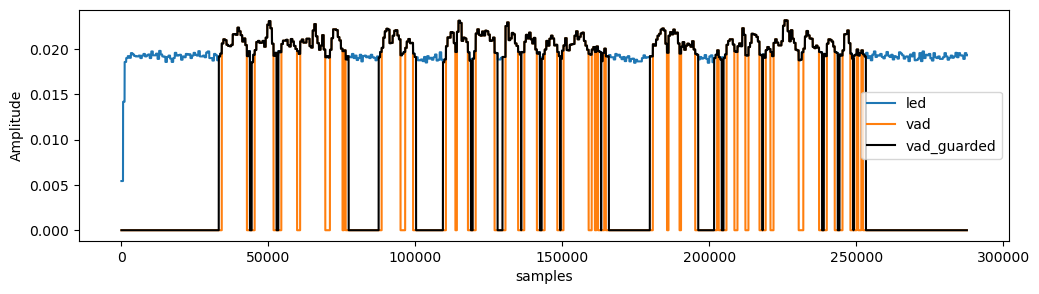

In [41]:
# process the VAD
# vad threshold are defined for the int16 format, as read by scipy.io.wavfile.read
vad_thresh = {"5": 650, "10": 600, "15": 540, "20": 425, "25": 340}  # 2017/12/07
fs, wav = wavfile.read(path_to_data / file_pattern.format(MIC, "mix", SIR))
intinfo = np.iinfo(wav.dtype)
print(intinfo.max)
print(-intinfo.min)

vad_snd = led > vad_thresh[SIR] / intinfo.max
 
plt.figure(figsize=(12,3))
plt.plot(led, label='led')
plt.plot(vad_snd * led, label='vad')

# Now we want to make sure no speech speech goes in estimation of the noise covariance matrix.
# For that we will remove frames neighbouring the detected speech
vad_guarded = vad_snd.copy()
if vad_guard is not None:
    for i, v in enumerate(vad_snd):
        if np.any(vad_snd[i - vad_guard : i + vad_guard]):
            vad_guarded[i] = True

plt.plot(vad_guarded * led, 'k', label='vad_guarded')
plt.xlabel('samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

vad = vad_guarded

# Create a PRA Room

In [42]:
rt60 = 0.5  # seconds
e_absorption, max_order = pra.inverse_sabine(rt60, room_dim)

print("absorption = ", e_absorption)
print("max_order = ", max_order)

room = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order)
room.add_source(src_pos[0]) # speech
room.add_source(src_pos[1]) # noise
room.add_microphone_array(pra.MicrophoneArray(mic_pos.T, fs=room.fs))

# anechoic room, usefull fro computing anechoic images
aroom = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=0)
aroom.add_microphone_array(pra.MicrophoneArray(mic_pos.T, fs=room.fs))
aroom.add_source(src_pos[0]) # speech
aroom.add_source(src_pos[1]) # noise

absorption =  0.25526524191592753
max_order =  69


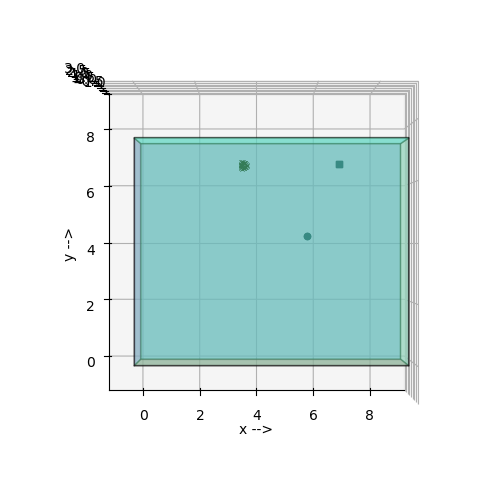

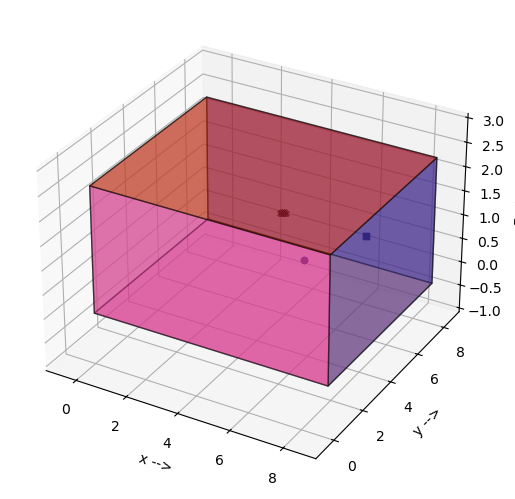

In [43]:
fig, ax = room.plot()
ax.set_xlim([-1, 9])
ax.set_ylim([-1, 9])
ax.set_zlim([-1, 3])
ax.set_xlabel("x -->")
ax.set_ylabel("y -->")
# top view
ax.view_init(elev=90, azim=-90)
plt.show()

fig, ax = room.plot()
ax.set_xlim([-1, 9])
ax.set_ylim([-1, 9])
ax.set_zlim([-1, 3])
ax.set_xlabel("x -->")
ax.set_ylabel("y -->")
ax.set_zlabel("z -->")
plt.show()

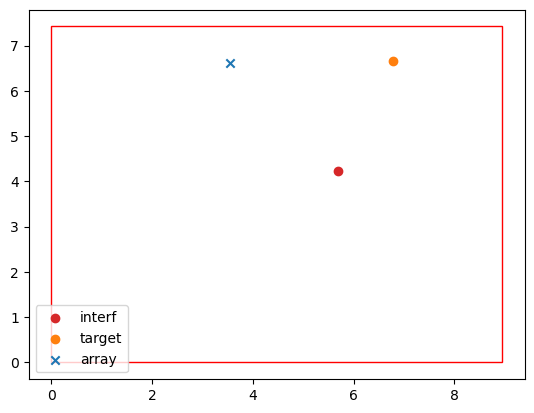

In [44]:
fig, ax = plt.subplots()

plt.scatter(src_pos[0,0], src_pos[0,1], c='C3', label='interf')
plt.scatter(src_pos[1,0], src_pos[1,1], c='C1', label='target')
plt.scatter(ref_pos[0], ref_pos[1], c='C0', marker='x', label='array')

rect = patches.Rectangle((0, 0), room_dim[0], room_dim[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.legend(loc='lower left')
plt.show()

# Compute images and echoes parameters

In [45]:
room.compute_rir()
aroom.compute_rir()

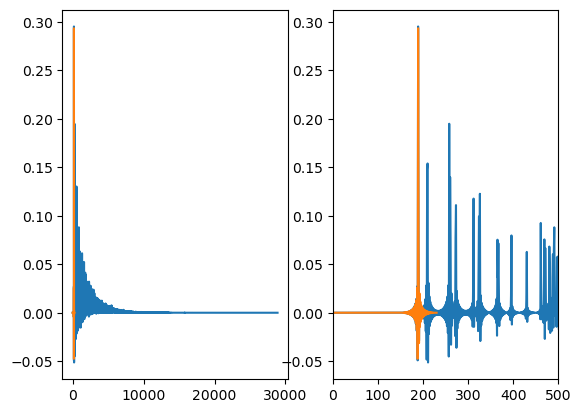

In [46]:
rirs = room.rir
arirs = aroom.rir

plt.subplot(1,2,1)
plt.plot(rirs[0][0])
plt.plot(arirs[0][0])
plt.subplot(1,2,2)
plt.plot(rirs[0][0])
plt.plot(arirs[0][0])
plt.xlim([0, 500])
plt.show()

In [82]:
doas = []
coeffs = []
toas = []
images = []

for s, source in enumerate(room.sources):
    
    src_images_pos =  room.sources[s].images
    src_images_order = room.sources[s].orders
    src_images_dampings = room.sources[s].damping

    src_images_dist = np.linalg.norm(src_images_pos - ref_pos[:,None], axis=0)
    # sort accoding to distance
    idx = np.argsort(src_images_dist)
    print(idx)
    idx = idx[:100]
    src_images_dist = src_images_dist[idx]
    src_images_pos = src_images_pos[:,idx]
    src_images_dampings = src_images_dampings[:,idx]

    # IMS VALUE
    coeffs.append(src_images_dampings.squeeze() / src_images_dist)

    # angle between image and reference point
    n_theta = src_images_pos - ref_pos[:,None]
    doas_images = np.arctan2(n_theta[1], n_theta[0]) 
    doas_images = np.mod(doas_images, 2*np.pi)
    doas_gt = doas_images
    toas_gt = src_images_dist / room.c

    doas.append(doas_gt)
    toas.append(toas_gt)
    images.append(src_images_pos)

doas = np.array(doas)
toas = np.array(toas)
coeffs = np.array(coeffs)
images = np.array(images)

print('DOAS', doas.shape)
print('TOAS', toas.shape)
print('COEFFS', coeffs.shape)
print('IMAGES', images.shape)

[223859 214336 223997 ... 223789 223928 223790]
[223859 223997 214336 ... 223789 223928 223790]
DOAS (2, 100)
TOAS (2, 100)
COEFFS (2, 100)
IMAGES (2, 3, 100)


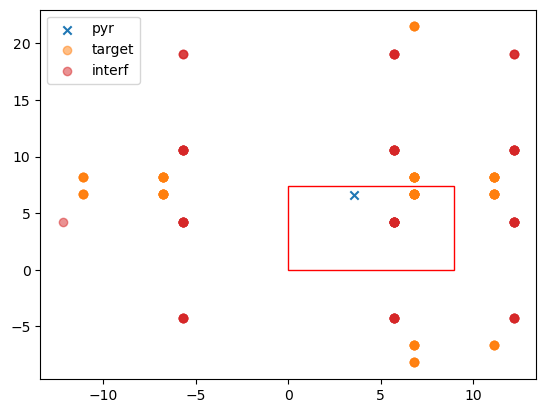

In [83]:
fig, ax = plt.subplots()

plt.scatter(ref_pos[0], ref_pos[1], c='C0', marker='x', label='pyr')

plt.scatter(src_pos[1,0], src_pos[1,1], c='C1')
plt.scatter(images[1][0], images[1][1], c='C1', alpha=0.5, label='target')

plt.scatter(src_pos[0,0], src_pos[0,1], c='C3')
plt.scatter(images[0][0], images[0][1], c='C3', alpha=0.5, label='interf')


rect = patches.Rectangle((0, 0), room_dim[0], room_dim[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.legend()

[ 24.88977248  55.22691348  61.86304495  80.22529752 126.59427933
 156.54609478 188.63483608 194.50046819 229.51697292 281.20205886
 308.59588399 311.89573003 344.53982839]
[ True  True  True  True  True  True  True  True  True  True  True  True]
[ 24.88977248  55.22691348  61.86304495  80.22529752 126.59427933
 156.54609478 188.63483608 194.50046819 229.51697292 281.20205886
 308.59588399 311.89573003]
[  0.34095314   0.79868372  11.76526302  26.00859017  77.76574989
 171.32930758 173.86876754 179.75035809 179.82415019 282.30640259
 283.67494306 299.682519  ]
[False  True  True  True  True  True  True False  True False  True]
[  0.79868372  11.76526302  26.00859017  77.76574989 171.32930758
 173.86876754 179.82415019 283.67494306]


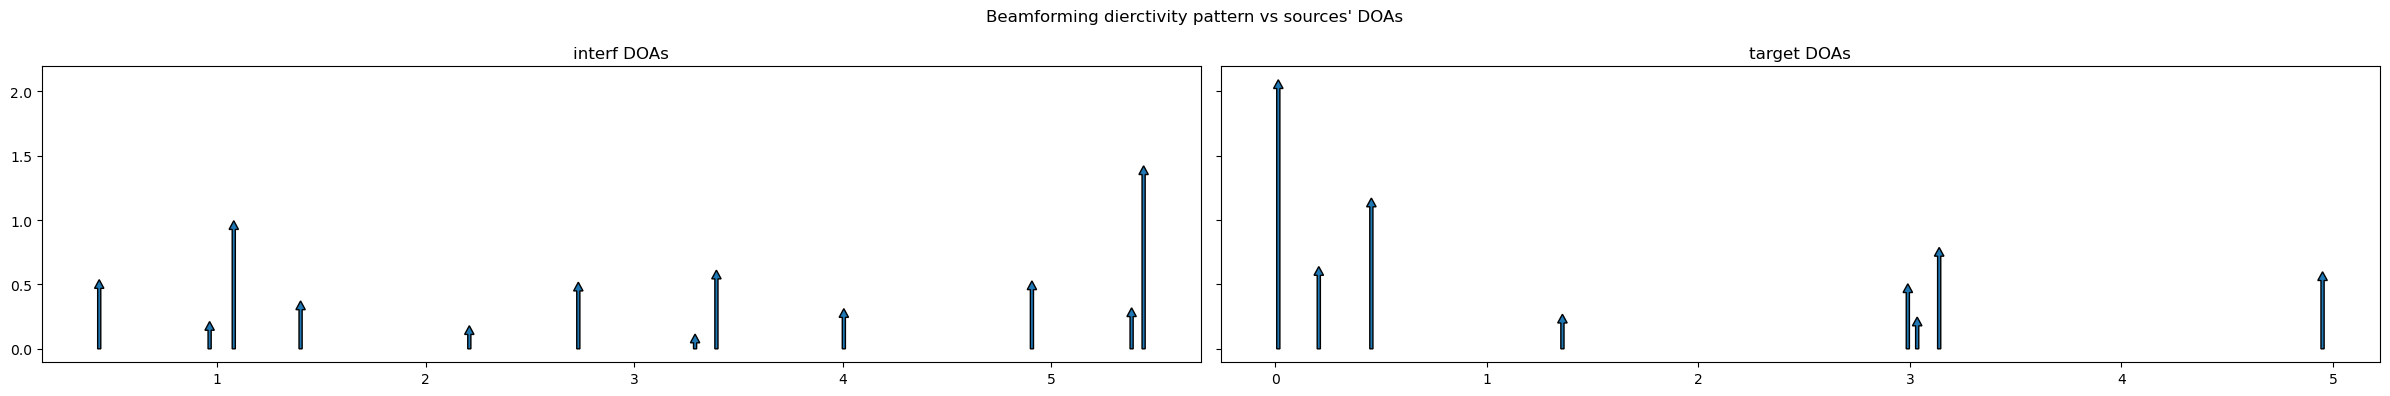

In [147]:
fig_pol, axarr_pol = plt.subplots(1, 2, figsize=(24,4), sharey=True)
# fig_pol, axarr_pol = plt.subplots(1, 2, figsize=(8,4), sharey=True, subplot_kw={'projection': 'polar'})

source_name = ['interf', 'target']

thr = 2 # degree

sources_doas_energy = {}

for src_idx in [0, 1]:

    doas_ = doas[src_idx]
    unique_doas = np.unique(doas_)
    
    unique_doas = np.sort(unique_doas)

    print(np.rad2deg(unique_doas))
    print(np.diff(np.rad2deg(unique_doas)) > thr)
    unique_doas = unique_doas[np.where(np.diff(np.rad2deg(unique_doas)) > thr)]    
    print(np.rad2deg(unique_doas))
    assert np.all(np.rad2deg(np.diff(unique_doas)) > thr)
                      
    idx = np.argsort(coeff_)[::-1]
    
    # energy per doa
    energy_per_unique_doas = np.zeros_like(unique_doas)
    for d, doa in enumerate(unique_doas):
        idx = np.where(np.abs(doas_ - doa) < np.deg2rad(thr))[0]
        # print(np.rad2deg(doa), idx)
        energy_per_unique_doas[d] = np.sum(np.abs(coeffs[src_idx,idx]))
    
    doas_ = unique_doas
    coeff_ = energy_per_unique_doas
    
    sources_doas_energy[source_name[src_idx]] = (doas_, coeff_)

    # polar plot
    for d, (doa, coeff) in enumerate(zip(doas_, coeff_)):
        axarr_pol[src_idx].arrow(doa, 0, 0, coeff, width = 0.015, edgecolor = 'black', facecolor = 'C0', lw = 1, zorder = 2)

    axarr_lin[src_idx].set_title('{} DOAs'.format(source_name[src_idx]))
    axarr_pol[src_idx].set_title('{} DOAs'.format(source_name[src_idx]))


fig_pol.suptitle("Beamforming dierctivity pattern vs sources' DOAs")
fig_pol.tight_layout()
plt.show()

# STFT analysis

(24, 513, 562)


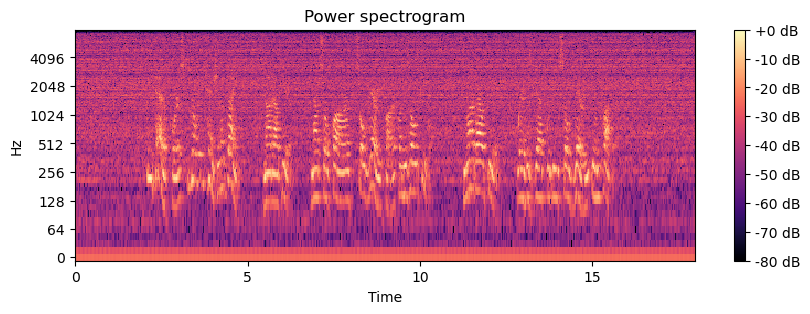

In [49]:
analysis = lambda x : lr.stft(x, n_fft=NFFT, hop_length=NFFT//2)

X = analysis(mix.T)
print(X.shape)

fig, ax = plt.subplots(figsize=(10, 3))
img = lr.display.specshow(lr.amplitude_to_db(np.abs(X[0,:]), ref=np.max), y_axis='log', x_axis='time', ax=ax, sr=fs)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

X_s (24, 513, 562)


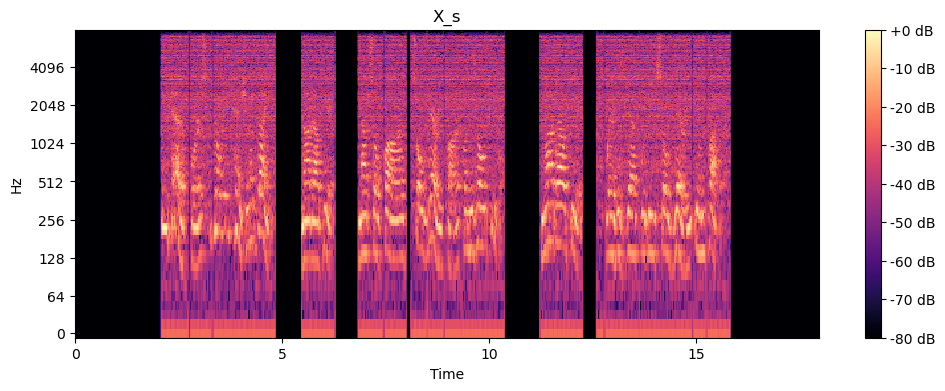

X_n (24, 513, 562)


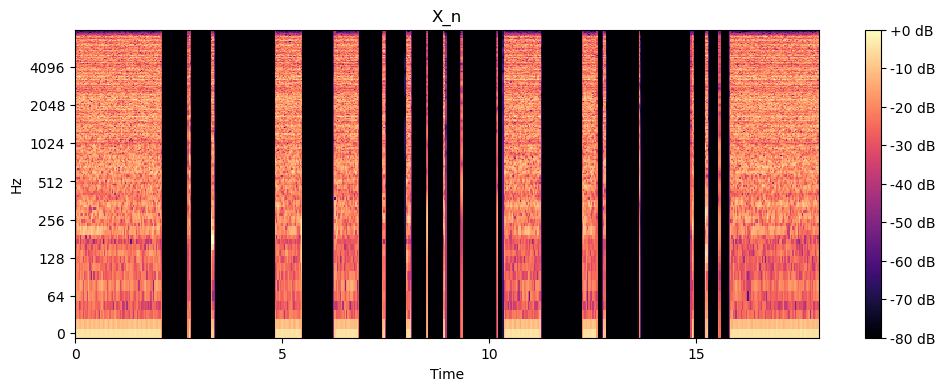

In [50]:
X_s = analysis(vad * mix.T)
print('X_s', X_s.shape)

fig, ax = plt.subplots(figsize=(12, 4))
img = lr.display.specshow(lr.amplitude_to_db(np.abs(X_s[0,:]), ref=np.max), y_axis='log', x_axis='time', ax=ax, sr=fs)
ax.set_title('X_s')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

X_n = analysis((1-vad) * mix.T)
print('X_n', X_n.shape)

fig, ax = plt.subplots(figsize=(12, 4))
img = lr.display.specshow(lr.amplitude_to_db(np.abs(X_n[0,:]), ref=np.max), y_axis='log', x_axis='time', ax=ax, sr=fs)
ax.set_title('X_n')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()



# fig, ax = plt.subplots(figsize=(10, 3))
# img = lr.display.specshow(np.abs(VAD), y_axis='log', x_axis='time', ax=ax, sr=fs)
# ax.set_title('VAD')
# fig.colorbar(img, ax=ax, format="%+2.0f dB")
# plt.show()

In [51]:
nChan, nFreq, nTime = X_s.shape
X_s_ = X_s.transpose(2,1,0)
X_n_ = X_n.transpose(2,1,0)


Rs = np.einsum("i...j,i...k->...jk", X_s_, np.conj(X_s_)) / X_s_.shape[-1]
Rn = np.einsum("i...j,i...k->...jk", X_n_, np.conj(X_n_)) / X_n_.shape[-1]

print('Rs', Rs.shape)
print('Rn', Rn.shape)

def max_sinr_weights_per_freq(Rs, Rn, n_channels):
    return sp.linalg.eigh(Rs, b=Rn, eigvals=(n_channels - 1, n_channels - 1),)[1]


w = [max_sinr_weights_per_freq(Rs[f], Rn[f], n_channels=nChan) for f in range(1, nFreq)]
w = np.squeeze(np.array(w))
print(w.shape)

Rs (513, 24, 24)
Rn (513, 24, 24)
(512, 24)


In [52]:
# postprocess the weights
nw = sp.linalg.norm(w, axis=1)
w[nw > 1e-10, :] /= nw[nw > 1e-10, None]

w = np.concatenate([np.ones((1, nChan)), w], axis=0)

from max_sinr_beamforming import compute_gain
print(X_s_.shape)
print(w.shape)
z = compute_gain(w, X_s_, X_s_[:, :, 0])
w *= z[:, None]

(562, 513, 24)
(513, 24)


In [65]:
# create the steering vectors for the mic array
theta = np.deg2rad(np.arange(0, 361, 1))
vect_doa_src = np.stack([np.cos(theta), np.sin(theta), np.zeros_like(theta)])
print(vect_doa_src.shape)

vect_mics = mic_pos
print(vect_mics.shape)

toas_far_free = vect_doa_src.T @ vect_mics.T / room.c # nDoas x nChan
freqs = np.fft.rfftfreq((nFreq-1)*2, 1/fs)

svects = np.exp(- 1j * 2 * np.pi * freqs[:,None,None] * (toas_far_free[None,...])) #  nFreq x nDoas x nChan
print(svects.shape)

(3, 361)
(24, 3)
(513, 361, 24)


(513, 361, 24)
(513, 24)


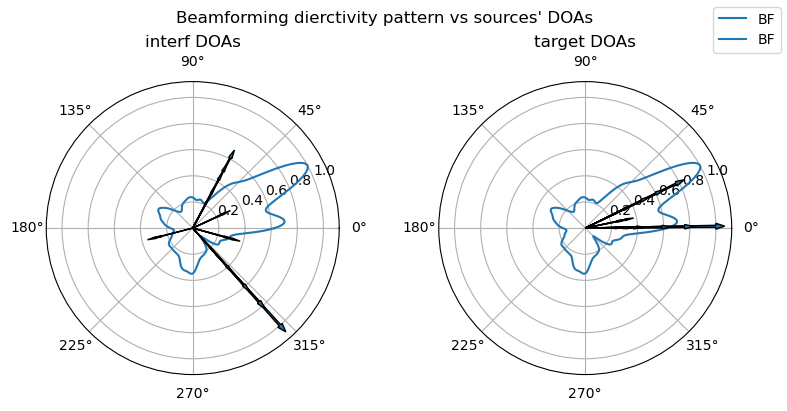

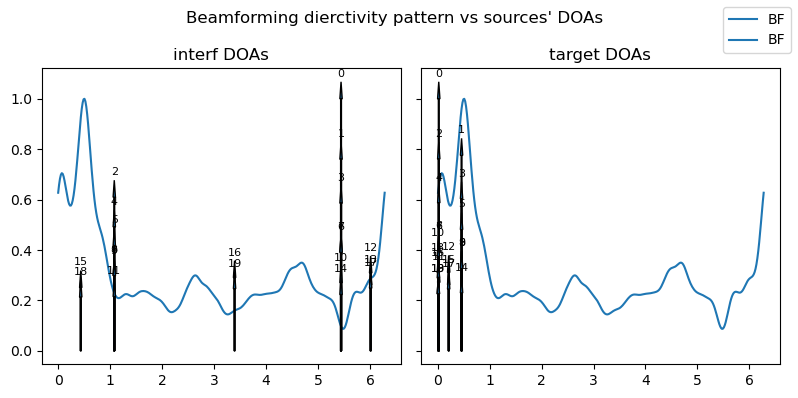

In [54]:
print(svects.shape)
print(w.shape)

bf_freq = np.abs(np.einsum('fm,fsm->fs', w, svects))**2
# mean over freqs
bf = np.mean(bf_freq, 0)
# normalize
bf = bf / np.max(np.abs(bf))


fig_pol, axarr_pol = plt.subplots(1, 2, figsize=(8,4), sharey=True, subplot_kw={'projection': 'polar'})
fig_lin, axarr_lin = plt.subplots(1, 2, figsize=(8,4), sharey=True)

source_name = ['interf', 'target']

for src_idx in [0, 1]:

    doas_ = doas[src_idx]
    coeff_ = coeffs[src_idx]
    coeff_ = coeff_ / np.max(coeff_)

    # idx_ = np.argsort(coeff_)[::-1]
    
    # doas_ = doas_[idx_]
    # coeff_ = coeff_[idx_]
    
    R = 20
    doas_ = doas_[:R]
    coeff_ = coeff_[:R]

    # polar plot

    axarr_pol[src_idx].plot(theta, bf, label='BF')
    axarr_lin[src_idx].plot(theta, bf, label='BF')
    for d, (doa, coeff) in enumerate(zip(doas_, coeff_)):
        axarr_pol[src_idx].arrow(doa, 0, 0, coeff, width = 0.015, edgecolor = 'black', facecolor = 'C0', lw = 1, zorder = 5)
        # add text on the tip of the arrow
        axarr_lin[src_idx].arrow(doa, 0, 0, coeff, width = 0.015, edgecolor = 'black', facecolor = 'C0', lw = 1, zorder = 5)
        axarr_lin[src_idx].text(doa, coeff + 0.1, f"{d}", fontsize=8, ha='center', va='center')

    axarr_lin[src_idx].set_title('{} DOAs'.format(source_name[src_idx]))
    axarr_pol[src_idx].set_title('{} DOAs'.format(source_name[src_idx]))


fig_pol.suptitle("Beamforming dierctivity pattern vs sources' DOAs")
fig_lin.suptitle("Beamforming dierctivity pattern vs sources' DOAs")
fig_lin.legend()
fig_pol.legend()
fig_lin.tight_layout()
fig_pol.tight_layout()
plt.show()

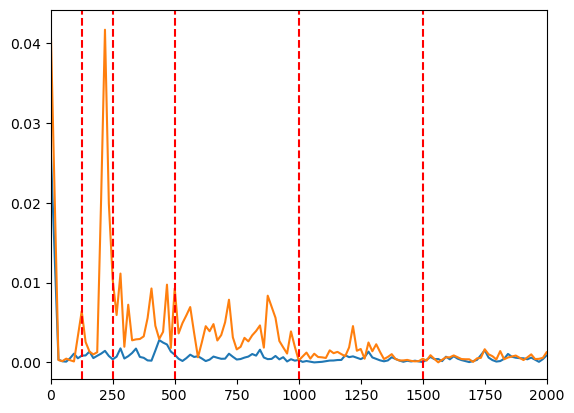

8
125.0
16
250.0
32
500.0
64
1000.0
96
1500.0
[125.0, 218.75, 468.75, 968.75, 1531.25]


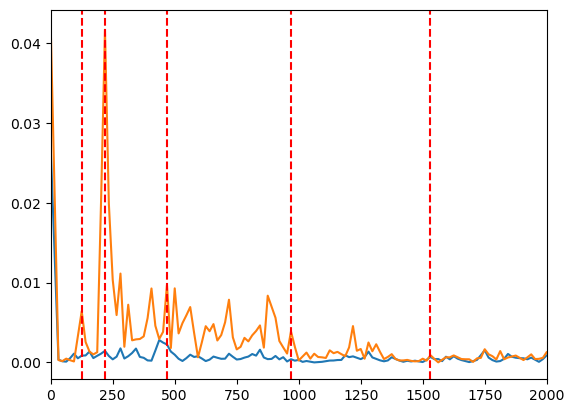

In [254]:
X_n_freq = np.abs(np.mean(X_n, axis=(0,2)).T)
X_s_freq = np.abs(np.mean(X_s, axis=(0,2)).T)

max_val = np.max([X_n_freq, X_s_freq])

plt.plot(freqs, X_n_freq)
plt.plot(freqs, X_s_freq)

freqs_to_plot = [125, 250, 500, 1000, 1500]
for freq in freqs_to_plot:
    plt.axvline(x=freq, color='r', linestyle='--')
plt.xlim([0, 2000])
plt.show()

for f, freq in enumerate(freqs_to_plot):
    freq_idx = np.argmin(np.abs(freqs - freq))
    print(freq_idx)
    print(freqs[freq_idx])
    freqs_to_plot[f] = freqs[np.argmax(X_s_freq[freq_idx-3:freq_idx+3]) + freq_idx-3]
print(freqs_to_plot)

plt.plot(freqs, X_n_freq)
plt.plot(freqs, X_s_freq)
for freq in freqs_to_plot:
    plt.axvline(x=freq, color='r', linestyle='--')
plt.xlim([0, 2000])
plt.show()


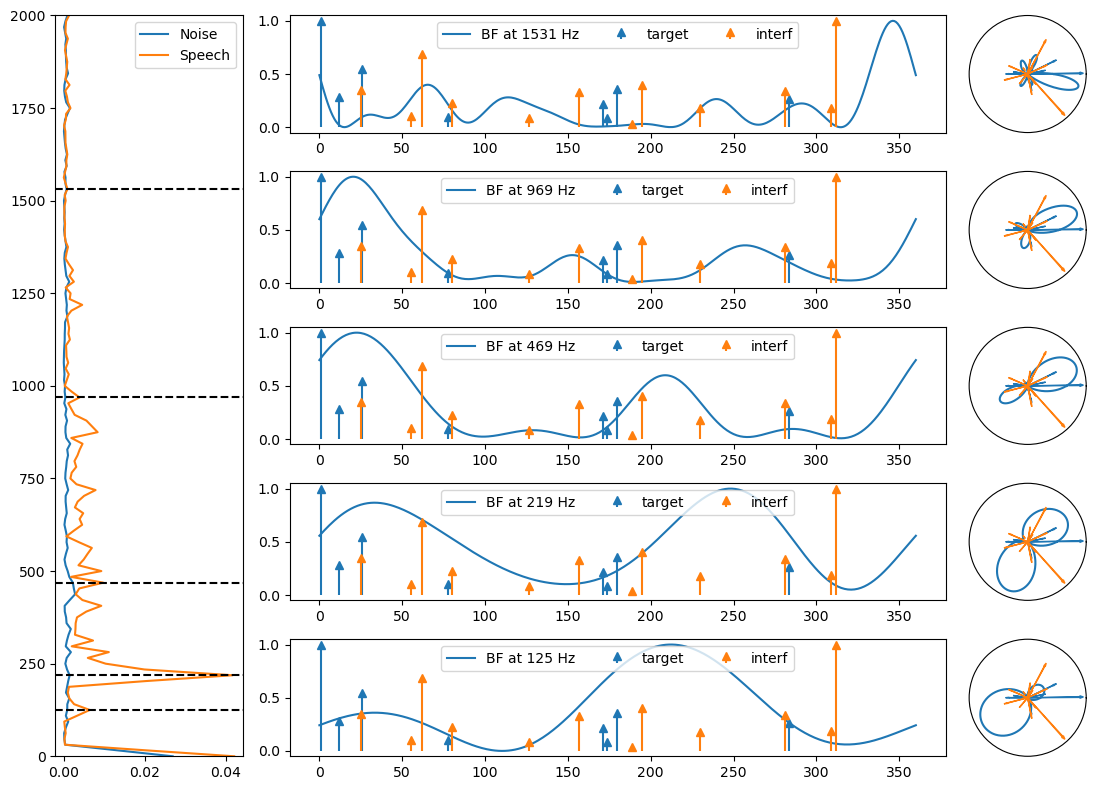

In [279]:
def generate_axes(fig):
    gridspec = fig.add_gridspec(nrows=15, ncols=10)
    axes = {}
    axes['spec'] = fig.add_subplot(gridspec[0:15, 0:2])
    axes['lin_doas5'] = fig.add_subplot(gridspec[0:3, 2:8])
    axes['pol_doas5'] = fig.add_subplot(gridspec[0:3, 7:10], projection='polar')
    axes['lin_doas4'] = fig.add_subplot(gridspec[3:6, 2:8])
    axes['pol_doas4'] = fig.add_subplot(gridspec[3:6, 7:10], projection='polar')
    axes['lin_doas3'] = fig.add_subplot(gridspec[6:9, 2:8])
    axes['pol_doas3'] = fig.add_subplot(gridspec[6:9, 7:10], projection='polar')
    axes['lin_doas2'] = fig.add_subplot(gridspec[9:12, 2:8])
    axes['pol_doas2'] = fig.add_subplot(gridspec[9:12, 7:10], projection='polar')
    axes['lin_doas1'] = fig.add_subplot(gridspec[12:15, 2:8])
    axes['pol_doas1'] = fig.add_subplot(gridspec[12:15, 7:10], projection='polar')
    return axes

fig = plt.figure(figsize=(12, 8))
axes = generate_axes(fig)
axes['spec'].plot(X_n_freq, freqs, label='Noise')
axes['spec'].plot(X_s_freq, freqs, label='Speech')
axes['spec'].set_ylim([0, 2000])
axes['spec'].legend()


for f, freq in enumerate(freqs_to_plot):
    freq_idx = np.argmin(np.abs(freqs - freq))
    curr_bf = bf_freq[freq_idx] / np.max(bf_freq[freq_idx])
    axes[f'lin_doas{f+1}'].plot(np.rad2deg(theta), curr_bf, label=f'BF at {freq:.0f} Hz')
    axes[f'pol_doas{f+1}'].plot(theta, curr_bf, label=f'{freq:.0f} Hz')
    axes[f'pol_doas{f+1}'].set_xticks([])
    axes[f'pol_doas{f+1}'].set_yticks([])
    
    for src_name, color in zip(['target', 'interf'], ['C0', 'C1']):
        doas_ = sources_doas_energy[src_name][0]
        coeff_ = sources_doas_energy[src_name][1]
        coeff_ = coeff_ / np.max(coeff_)
        for i, (doa, coeff) in enumerate(zip(doas_, coeff_)):   
            if i == 0:
                axes[f'pol_doas{f+1}'].arrow(doa, 0, 0, coeff, width = 0.015, edgecolor = color, facecolor = color, lw = 1, zorder = 5, label=src_name)
            else:
                axes[f'pol_doas{f+1}'].arrow(doa, 0, 0, coeff, width = 0.015, edgecolor = color, facecolor = color, lw = 1, zorder = 5)
        axes[f'lin_doas{f+1}'].stem(np.rad2deg(doas_), coeff_, 
                                    markerfmt=f'{color}^', 
                                    linefmt=f'{color}',
                                    basefmt=' ', label=src_name)
        # axes[f'pol_doas{f+1}'].stem(doas_, coeff_, markerfmt=f'{color}', basefmt=f'{color}', label=src_name)
                
    axes[f'lin_doas{f+1}'].legend(loc='upper center', ncols=3)
    
    axes['spec'].axhline(freq, color='k', linestyle='--')

plt.tight_layout()

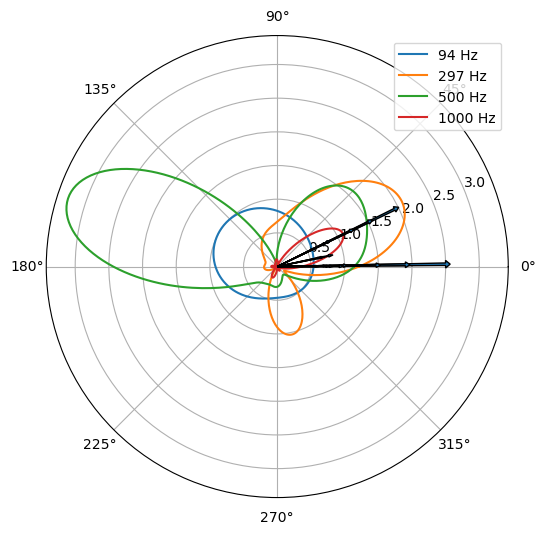

In [66]:
plt.figure(figsize=(6,6))
plt.subplot(111, polar=True)

# idx_freqs = np.linspace(10, nFreq // 2, 10).astype(int)
freqs_to_plot = [100, 300, 500, 1000]
idx_freqs = [np.argmin(np.abs(f - freqs)) for f in freqs_to_plot]

for f in idx_freqs:
    plt.plot(theta, bf_freq[f], label=f'{freqs[f]:.0f} Hz')
plt.legend()

for doa, coeff in zip(doas_, coeff_):
    plt.arrow(doa, 0, 0, 2.5*coeff, width = 0.015, edgecolor = 'black', facecolor = 'C0', lw = 1, zorder = 5)
plt.show()

# Metrics